In [7]:
import nolds
import pandas as pd
import numpy as np
import math
from fbm import *
import matplotlib.pyplot as plt

In [3]:
fbm = nolds.fbm(100, H=0.75)

In [4]:
fbm = pd.Series(fbm)

<AxesSubplot:>

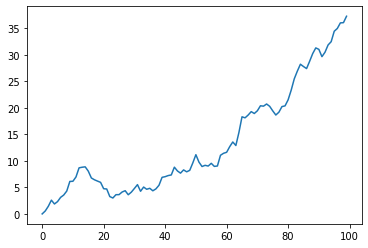

In [5]:
fbm.plot()

In [6]:
import yfinance as yf

In [7]:
ticker_symbol = 'CL=F'
start_date = '2000-01-01'
end_date = '2023-06-30'
data = yf.download(ticker_symbol, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [8]:
prices = data['Adj Close']

In [27]:
prices[-2000:]

Date
2015-07-23    48.450001
2015-07-24    48.139999
2015-07-27    47.389999
2015-07-28    47.980000
2015-07-29    48.790001
                ...    
2023-06-26    69.370003
2023-06-27    67.699997
2023-06-28    69.559998
2023-06-29    69.860001
2023-06-30    70.639999
Name: Adj Close, Length: 2000, dtype: float64

In [28]:
oil_h = nolds.hurst_rs(prices)

In [29]:
oil_fd = nolds.corr_dim(prices, 1)

In [30]:
oil_h + oil_fd # D = H - 2

1.9035872140123646

In [31]:
fbm_oil = nolds.fbm(100, H=oil_h)

In [32]:
fbm_oil = pd.Series(fbm_oil)

<AxesSubplot:>

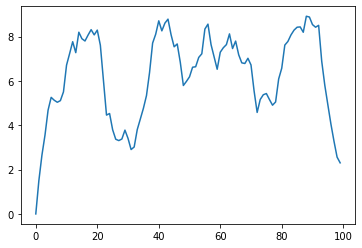

In [33]:
fbm_oil.plot()

In [49]:
from fbm import FBM
import numpy as np

# parameters
N = 100000
H = 0.60
S0 = 100  
K = 100  
T = 1.0  
r = 0.05  

# FBM object
f = FBM(n=N-1, hurst=H, length=T, method='daviesharte')

# Fractional Brownian motion 
fbm_sample = f.fbm()

# calculate its standard deviation as the volatility
sigma = np.std(fbm_sample)

# Create a function to simulate a price path
def simulate_path(S0, T, sigma, N, fbm_sample):
    dt = T/(N-1)
    return S0 * np.exp((r - 0.5*sigma**2)*np.linspace(0, T, N) + sigma*fbm_sample)

# paths
num_paths = 10000

# simulate price paths and calculate payoffs
payoffs = []
for _ in range(num_paths):
    path = simulate_path(S0, T, sigma, N, fbm_sample)
    payoff = np.maximum(path[-1] - K, 0)  # This is for a call option
    payoffs.append(payoff)

# Calculate the option price as the average discounted payoff
option_price = np.exp(-r*T) * np.mean(payoffs)

print("Option price: ", option_price)


Option price:  54.66748585148593


In [50]:
fbm_sample

array([ 0.00000000e+00,  2.60409555e-04, -7.38246918e-05, ...,
        1.13511583e+00,  1.13491645e+00,  1.13389500e+00])

### Experimenting with different stochastic models

In [3]:
# Binomail Multifractal Model

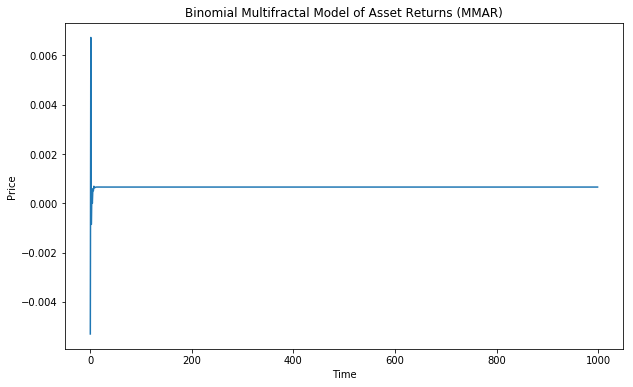

In [10]:
import numpy as np

def binomial_multifractal_model(time, M, lambda_):
    """
    Binomial Multifractal Model

    Parameters:
    time: length of the time series
    M: large number for computation
    lambda_: a parameter of the model

    Returns:
    price: a time series represents a price following MMAR
    """
    alpha = 0.5 + lambda_/2.
    beta = 0.5 - lambda_/2.
    
    # Generate two binomial random variables
    p = np.random.binomial(n=1, p=0.5, size=(M, time)) * 2 - 1
    epsilon = np.random.binomial(n=1, p=0.5, size=(M, time)) * 2 - 1

    # Calculate multipliers
    multiplier = np.cumprod(np.where(p == 1, alpha, beta), axis=1)

    # Calculate price
    price = np.cumsum(multiplier * epsilon, axis=1)

    return price

# Set parameters
time = 1000
M = 1000
lambda_ = 0.1

# Generate price series
price = binomial_multifractal_model(time, M, lambda_)

# Average price series
average_price = price.mean(axis=0)

# Plot the average price series
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(average_price)
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Binomial Multifractal Model of Asset Returns (MMAR)")
plt.show()

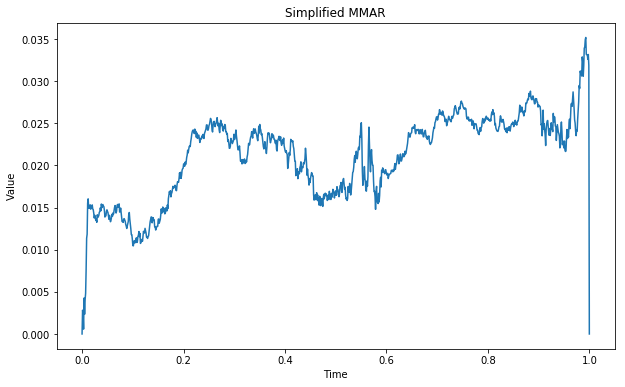

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def generate_multifractal_measure(hurst, num_intervals):
    """
    This function generates a multifractal measure using a multiplicative cascade.
    The weights of the subintervals are correlated, and their correlation is controlled by the Hurst parameter.
    """
    
    # Initialize measure with one interval [0, 1]
    measure = [(0, 1)]
    
    for _ in range(num_intervals):
        # Choose a random interval from measure
        index = np.random.randint(len(measure))
        a, b = measure.pop(index)
        
        # Choose a random point in the interval according to Beta distribution
        split_point = np.random.beta(a=hurst, b=hurst)
        
        # Add new intervals to measure
        measure.append((a, a + split_point * (b - a)))
        measure.append((a + split_point * (b - a), b))
    
    # Sort measure by interval start time
    measure.sort(key=lambda x: x[0])
    
    return measure

def generate_MMAR(hurst, num_intervals, mu, sigma, T, N):
    """
    This function generates a time series using the MMAR.
    """
    
    # Generate multifractal measure
    measure = generate_multifractal_measure(hurst, num_intervals)
    
    # Initialize MMAR
    MMAR = np.zeros(N)
    dt = T/N
    time_stamps = np.linspace(0, T, N)
    
    # Apply measure to time series
    for i in range(1, N):
        for a, b in measure:
            if a <= time_stamps[i] < b:
                MMAR[i] = MMAR[i-1] + np.sqrt(dt / (b - a)) * np.random.normal(mu * dt, sigma * np.sqrt(dt))
    
    return MMAR

# Set the parameters
hurst = 0.75
num_intervals = 10
mu = 0.1
sigma = 0.2
T = 1
N = 1000

# Generate MMAR
MMAR = generate_MMAR(hurst, num_intervals, mu, sigma, T, N)

# Plot the MMAR
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, T, N), MMAR)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Simplified MMAR')
plt.show()

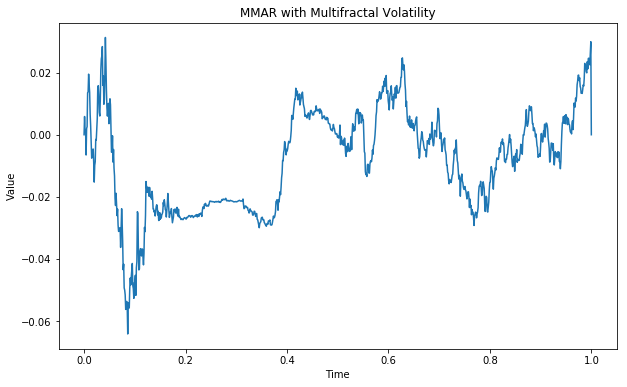

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def generate_multifractal_measure(hurst, num_intervals):
    """
    This function generates a binomial multifractal measure using a multiplicative cascade.
    The weights of the subintervals are correlated, and their correlation is controlled by the Hurst parameter.
    """
    alpha = 0.5 + hurst / 2
    beta = 0.5 - hurst / 2
    
    # Initialize measure with one interval [0, 1] and weight 1
    measure = [(0, 1, 1)]
    
    for _ in range(num_intervals):
        # Choose a random interval from measure
        index = np.random.randint(len(measure))
        a, b, w = measure.pop(index)
        
        # Generate a binomial random variable
        p = np.random.binomial(n=1, p=0.5)
        
        # Calculate new weights
        w_alpha = w * alpha if p == 1 else w * beta
        w_beta = w * beta if p == 1 else w * alpha
        
        # Add new intervals to measure
        measure.append((a, a + 0.5 * (b - a), w_alpha))
        measure.append((a + 0.5 * (b - a), b, w_beta))
    
    # Sort measure by interval start time
    measure.sort(key=lambda x: x[0])
    
    return measure

def generate_MMAR(hurst, num_intervals, mu, sigma, T, N):
    """
    This function generates a time series using the MMAR, with volatility as a function of the trading time.
    """
    # Generate multifractal measure
    measure = generate_multifractal_measure(hurst, num_intervals)
    
    # Initialize MMAR
    MMAR = np.zeros(N)
    dt = T / N
    time_stamps = np.linspace(0, T, N)
    
    # Apply measure to time series
    for i in range(1, N):
        for a, b, w in measure:
            if a <= time_stamps[i] < b:
                dW = np.random.normal(0, np.sqrt(dt))
                volatility = sigma * np.sqrt(w)
                MMAR[i] = MMAR[i-1] + mu * w * dt + volatility * dW
    
    return MMAR

# Set the parameters
hurst = 0.75
num_intervals = 10
mu = 0.1
sigma = 0.2
T = 1
N = 1000

# Generate MMAR
MMAR = generate_MMAR(hurst, num_intervals, mu, sigma, T, N)

# Plot the MMAR
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, T, N), MMAR)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('MMAR with Multifractal Volatility')
plt.show()

In [28]:
MMAR

array([ 0.00000000e+00,  5.86639610e-03,  1.20466321e-03,  1.39765427e-03,
       -6.53101161e-03,  1.97888967e-03,  2.60459226e-03,  1.35138437e-02,
        1.37974012e-02,  1.95121028e-02,  1.61324875e-02,  1.36188031e-02,
        6.58690950e-03,  2.79180855e-03, -2.12581151e-03, -7.54249143e-03,
       -6.31474157e-03, -4.73682965e-03, -4.61457410e-03, -9.00363324e-03,
       -1.52526312e-02, -9.84938941e-03, -8.67827692e-03, -1.52676076e-03,
       -1.67595973e-03,  1.73870013e-03,  5.22095883e-03,  1.53547802e-02,
        1.57906456e-02,  1.29458616e-02,  7.21276933e-03,  6.03171142e-03,
        1.13957197e-02,  2.08363265e-02,  2.44580665e-02,  2.54015093e-02,
        2.83916752e-02,  1.58896728e-02,  1.89105999e-02,  9.81451393e-03,
        1.12925313e-02,  1.96473956e-02,  3.13252332e-02,  2.38418080e-02,
        1.46263286e-02,  8.74659100e-03,  6.00370788e-03,  8.46390495e-03,
        1.01000905e-02,  3.55849457e-03,  8.85601869e-03,  1.15747157e-02,
        9.62273579e-03,  